In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import library machine Learning
import nltk 
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import gensim
from wordcloud import WordCloud
import re
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# download resource NLTK only once installed
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')

In [20]:
# load the dataset

df = pd.read_csv('datasets/dataset.csv')

display(df.head())


,video_id,title,channel_name,tanggal,author,komentar,label,komentar_clean,predicted_label
0,f8UEkmYXlzA,SKAKMAT AHOK,Pandji Pragiwaksono,1.745.412.234.123.970,TerranceNoelle-o9i,Makin yakin abis baca review lain tentang ✌✌𝐒𝐆...,1,makin yakin abis baca review lain tentang 𝐒𝐆𝐈𝟖𝟖 .,0
1,XI8K0-_kbHc,GAK NYANGKA BISA BEGINI! PENGENDARA DIJALAN SA...,Jejelogy,1.739.601.493.342.000,deraatvexplorerriders.2113,Paling suka model H2 😍🔥,0,suka model h2,0
2,nZoNbiwP2ZE,Akhirnya Selesai Subaru Crosstrek Family Drift...,Garasi Drift,1.739.772.479.808.090,risqokurniadi7208,Mobilnya udah hancur 🥺,0,mobilnya udah hancur,0
3,QpXcKzQInXg,Review Mobil Drift Seharga Super Car | BRZ V8 ...,Garasi Drift,1.738.825.556.100.780,LorrianeDotson,░𝙈𝘼𝙉𝙐𝙏88░benar2 bikin aku jadi sultan,1,░𝙈𝘼𝙉𝙐𝙏88░benar2 bikin sultan,1
4,nZoNbiwP2ZE,Akhirnya Selesai Subaru Crosstrek Family Drift...,Garasi Drift,1.739.858.865.953.920,Elpoco7365,Semoga lekas recover mobilnya mas Dipo,0,semoga lekas recover mobilnya mas dipo,0


In [21]:
missing_values = df.isnull().sum()
print("Amount of duplicates column")
print(missing_values)
print("\n")

duplicate_rows = df.duplicated().sum()
print(f"Amount Rows has duplicates: {duplicate_rows} Rows\n")

if duplicate_rows > 0:
    print("Example column duplicate:")
    print(df[df.duplicated(keep=False)]) 
print("\n")


Amount of duplicates column
video_id           0
title              0
channel_name       0
tanggal            0
author             0
komentar           0
label              0
komentar_clean     0
predicted_label    0
dtype: int64


Amount Rows has duplicates: 0 Rows





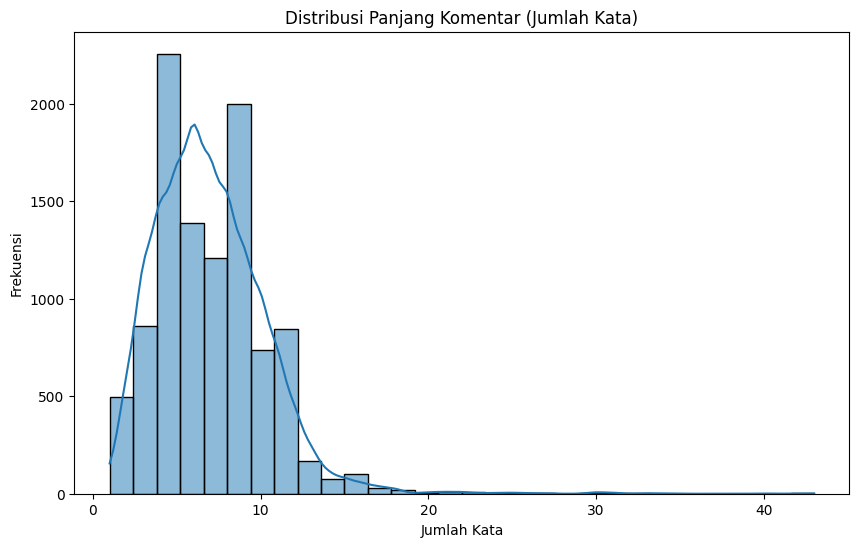

In [22]:
# checking outliers

df['panjang_komentar'] = df['komentar'].dropna().str.split().str.len() #make sure column komentar dosent have Nan

# visualization for checking outliers
plt.figure(figsize=(10, 6))
sns.histplot(df['panjang_komentar'], bins=30, kde=True)
plt.title('Distribusi Panjang Komentar (Jumlah Kata)')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.show()

Proceed EDA

--- Analysis Distribution Label ---


/tmp/ipykernel_23836/2509166749.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label', data=df, palette=['#3498db', '#e74c3c'])


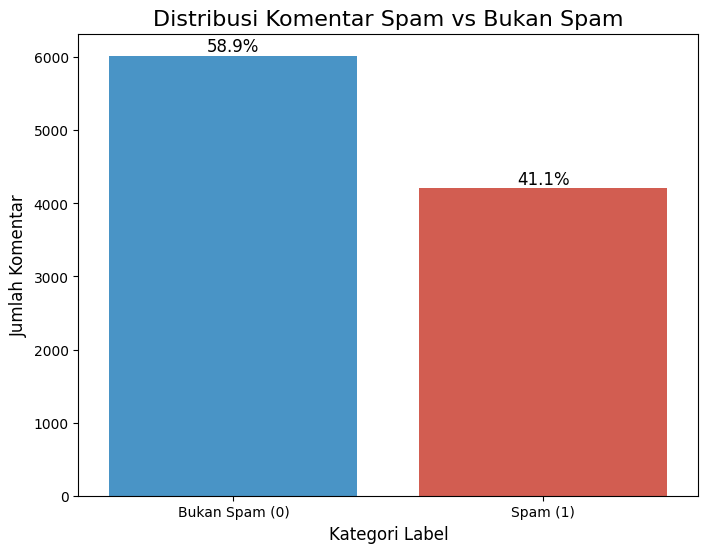


--- Menganalisis Kata Kunci (Word Cloud & Frekuensi N-gram) ---


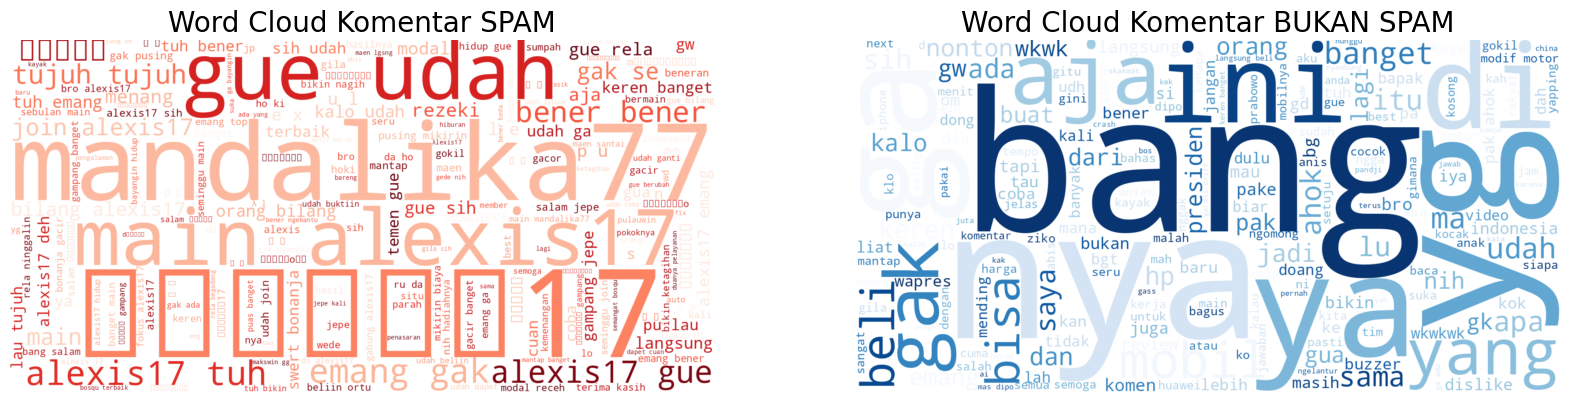

/tmp/ipykernel_23836/2509166749.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='bigram', data=df_spam_bigrams, palette='viridis')


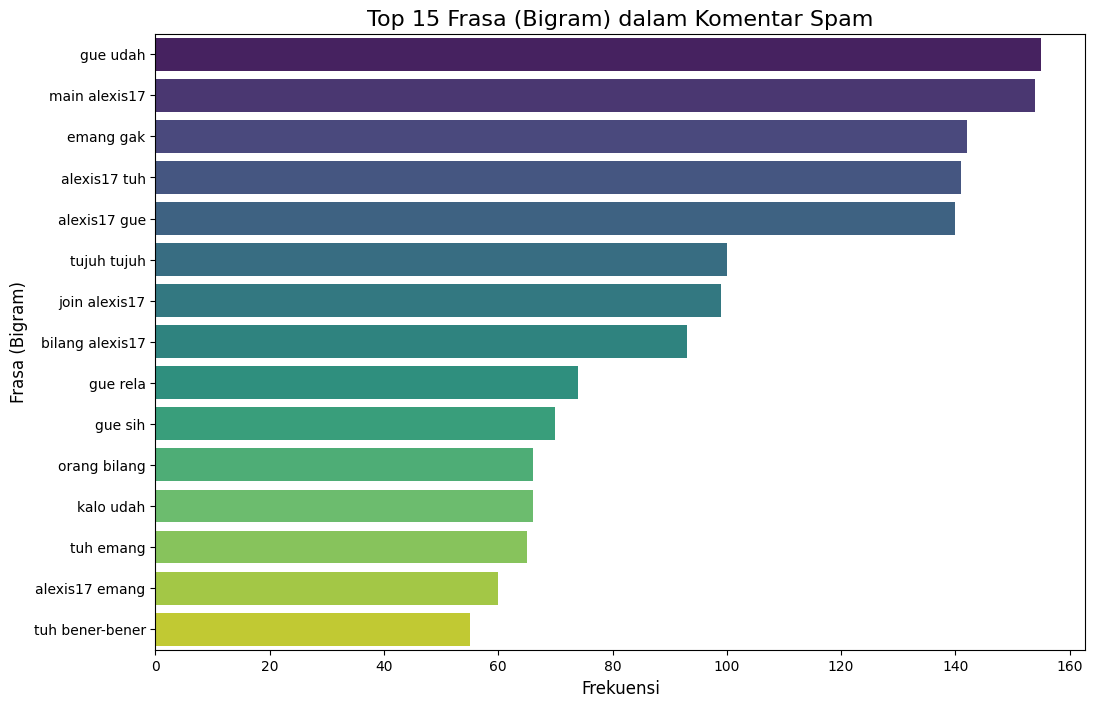


Proses EDA selesai.


In [23]:
print("Proceed EDA")
print("\n--- Analysis Distribution Label ---")
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='label', data=df, palette=['#3498db', '#e74c3c']) 

plt.title('Distribusi Komentar Spam vs Bukan Spam', fontsize=16)
plt.xlabel('Kategori Label', fontsize=12)
plt.ylabel('Jumlah Komentar', fontsize=12)
plt.xticks([0, 1], ['Bukan Spam (0)', 'Spam (1)'], fontsize=10)

total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12)

plt.show()


print("\n--- Menganalisis Kata Kunci (Word Cloud & Frekuensi N-gram) ---")

df['komentar_clean'] = df['komentar_clean'].astype(str) 
spam_comments_df = df[df['label'] == 1]
non_spam_comments_df = df[df['label'] == 0]

spam_text = " ".join(comment for comment in spam_comments_df.komentar_clean)
non_spam_text = " ".join(comment for comment in non_spam_comments_df.komentar_clean)

if spam_text and non_spam_text:
    wordcloud_spam = WordCloud(width=1600, height=800, background_color='white', colormap='Reds').generate(spam_text)
    wordcloud_non_spam = WordCloud(width=1600, height=800, background_color='white', colormap='Blues').generate(non_spam_text)

    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    axes[0].imshow(wordcloud_spam, interpolation='bilinear')
    axes[0].set_title('Word Cloud Komentar SPAM', fontsize=20)
    axes[0].axis('off')

    axes[1].imshow(wordcloud_non_spam, interpolation='bilinear')
    axes[1].set_title('Word Cloud Komentar BUKAN SPAM', fontsize=20)
    axes[1].axis('off')

    plt.show()
else:
    print("Tidak cukup data untuk membuat Word Cloud.")

def get_top_ngrams(corpus, n=None, gram=2):
    """Fungsi untuk mendapatkan n-gram paling umum dari sebuah teks."""
    words = [word for word in re.split(r'\s+', corpus) if len(word) > 2 and not word.isdigit()]
    ngrams = zip(*[words[i:] for i in range(gram)])
    ngram_counts = Counter([" ".join(ngram) for ngram in ngrams])
    return ngram_counts.most_common(n)

top_spam_bigrams = get_top_ngrams(spam_text, n=15, gram=2)

if top_spam_bigrams:
    df_spam_bigrams = pd.DataFrame(top_spam_bigrams, columns=['bigram', 'count'])

    plt.figure(figsize=(12, 8))
    sns.barplot(x='count', y='bigram', data=df_spam_bigrams, palette='viridis')
    plt.title('Top 15 Frasa (Bigram) dalam Komentar Spam', fontsize=16)
    plt.xlabel('Frekuensi', fontsize=12)
    plt.ylabel('Frasa (Bigram)', fontsize=12)
    plt.show()
else:
    print("Tidak cukup data untuk analisis N-gram pada komentar spam.")

print("\nProses EDA selesai.")

# MODELING 1 Naive Bayes + unigram (TF-IDF)

Data siap! Training: 8184 baris, Testing: 2046 baris.

sedang melatih model... (Machine Learning in progress)
Sedang menguji model...
Akurasi: 95.45%

Laporan Detail:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1168
           1       0.94      0.95      0.95       878

    accuracy                           0.95      2046
   macro avg       0.95      0.95      0.95      2046
weighted avg       0.95      0.95      0.95      2046



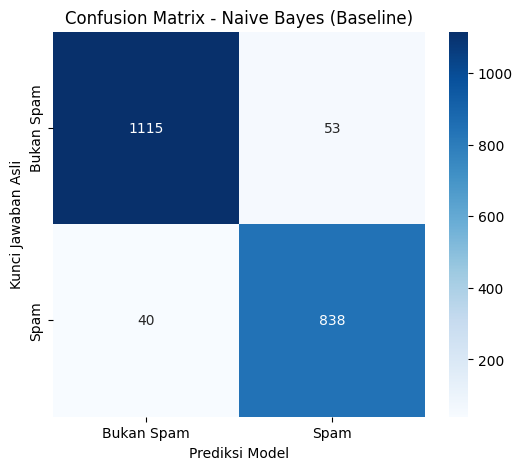

In [25]:
x = df['komentar']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(f"Data siap! Training: {len(X_train)} baris, Testing: {len(X_test)} baris.\n")

model_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Defaultnya udah Unigram (ngram_range=(1,1))
    ('algo', MultinomialNB())      # Algoritma Naive Bayes
])

print("sedang melatih model... (Machine Learning in progress)")
model_nb.fit(X_train, y_train)

print("Sedang menguji model...")
y_pred = model_nb.predict(X_test)

print(f"Akurasi: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("\nLaporan Detail:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Bukan Spam', 'Spam'], yticklabels=['Bukan Spam', 'Spam'])
plt.xlabel('Prediksi Model')
plt.ylabel('Kunci Jawaban Asli')
plt.title('Confusion Matrix - Naive Bayes (Baseline)')
plt.show()

# Model 2 Naive Bayes + TF IDF (Unigram + Bigram)

Training Model (machine learning in progress)
while testing model
Accuracy: 93.79%

Detail:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1168
           1       0.95      0.90      0.93       878

    accuracy                           0.94      2046
   macro avg       0.94      0.93      0.94      2046
weighted avg       0.94      0.94      0.94      2046



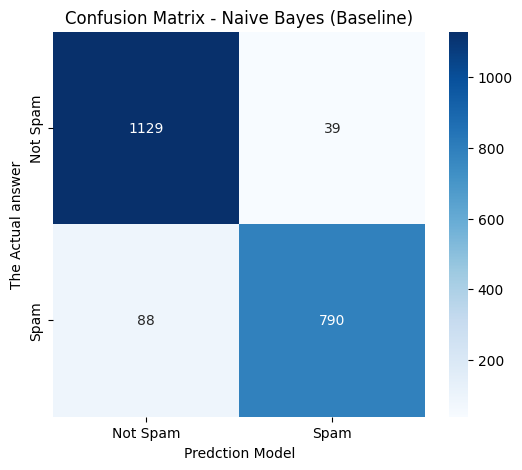

In [26]:
model_nb_bigram = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(2,2))), 
    ('algo', MultinomialNB())      # Algorithm Naive Bayes
])

#Training data
print("Training Model (machine learning in progress)")
model_nb_bigram.fit(X_train, y_train)

#Testing 
print("while testing model")
y_pred_bigram = model_nb_bigram.predict(X_test)


# Evaluation 
acc_bigram = accuracy_score(y_test, y_pred_bigram)
print(f"Accuracy: {acc_bigram * 100:.2f}%")
print("\nDetail:")
print(classification_report(y_test, y_pred_bigram))

# VISUALISASI CONFUSION MATRIX 
plt.figure(figsize=(6, 5))
cm_bigram = confusion_matrix(y_test, y_pred_bigram)
sns.heatmap(cm_bigram, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.xlabel('Predction Model')
plt.ylabel('The Actual answer')
plt.title('Confusion Matrix - Naive Bayes (Baseline)')
plt.show()




In [27]:
try:
    print(f"Accuracy Comparisson:")
    print(f"Scenario 1 (Unigram): {accuracy_score(y_test, y_pred) * 100:.2f}%") #
    print(f"Scenario 2 (Bigram) : {acc_bigram * 100:.2f}%")
    
    if acc_bigram > accuracy_score(y_test, y_pred):
        print(" Conclusion: Add Bigram make accuracy increase !")
    else:
        print("Conclusion: Add Bigram make accuracy decrerase !")
except NameError:
    print("Run Model 1 to see comparisson")


Accuracy Comparisson:
Scenario 1 (Unigram): 95.45%
Scenario 2 (Bigram) : 93.79%
Conclusion: Add Bigram make accuracy decrerase !
